# TABLE OF CONTENTS:
---
* [General Information](#General-Information)
* [Setup](#Setup)
    * [Connect to Workspace](#Connect-to-Workspace)
* [Retrieve the Registered Model](#Retrieve-the-Registered-Model)
* [Retrieve the Registered Inference Environment](#Retrieve-the-Registered-Inference-Environment)
* [Inference Artifacts & Configuration](#Inference-Artifacts-&-Configuration)
* [Model Deployment (Local)](#Model-Deployment-(Local))
    * [Initial Deployment](#Initial-Deployment)
    * [Update Deployment](#Update-Deployment)
    * [Webservice Testing](#Webservice-Testing)
        * [Python SDK](#Python-SDK)
        * [Send HTTP Request](#Send-HTTP-Request)
* [Model Deployment (AKS Compute Target)](#Model-Deployment-(AKS-Compute-Target))
    * [Retrieve AKS cluster](#Retrieve-AKS-cluster)
    * [Deploy the Model as AKS Webservice](#Deploy-the-Model-as-AKS-Webservice)
    * [Retrieve Existing Webservice](#Retrieve-Existing-Webservice)
    * [Webservice Testing](#Webservice-Testing)
        * [Python SDK](#Python-SDK)
        * [Send HTTP Request](#Send-HTTP-Request)
* [Resource Clean Up](#Resource-Clean-Up)
---

In [4]:
test = "none"
test2 = "fowl-data"

In [5]:
if test:
    print("YES")

YES


# General Information

This notebook shows how to create test deployments for the model that has been trained in `02_model_training`. 

These test deployments are manual deployments using the Azure Machine Learning (AML) Python SDK and are part of the Experimentation Stage of the MLOps process. Only after test deployments are successful should the source code for the model be promoted from the GIT develop branch to the GIT main branch (via pull request).

In order to deploy models to the Sign Off Stage and eventually to the Execution Stage (production workloads), a deployment via Azure DevOps using the Kubernetes CLI (kubectl) is necessary instead. Respective Azure DevOps pipelines to deploy to the Sign Off and Execution Stages are provided as part of this project template. 

Manual deployments using **Model.deploy()** are therefore **only possible in the Experimentation Stage for model deployment testing** but cannot be used to deploy models to the Sign Off or Execution Stage.

# Setup

Append parent directory to sys path to be able to import created modules from src directory.

In [1]:
import sys
sys.path.append(os.path.dirname(os.path.abspath("")))

In [2]:
# Import libraries
import json
import matplotlib.pyplot as plt
import numpy as np
import requests
import torch
import torchvision
import torchvision.transforms as transforms
import uuid
from azureml.core import Environment, Workspace
from azureml.core.compute import AksCompute, ComputeTarget
from azureml.core.compute_target import ComputeTargetException
from azureml.core.container_registry import RegistryIdentity
from azureml.core.model import InferenceConfig, Model
from azureml.core.webservice import AciWebservice, AksWebservice, LocalWebservice, Webservice
from PIL import Image

# Import created modules
from src.training.data_utils import load_data, preprocess_image

### Connect to Workspace

In order to connect and communicate with the AML workspace, a workspace object needs to be instantiated using the AML Python SDK.

In [3]:
# Connect to the AML workspace
# For alternative connection options see the aml_snippets directory
ws = Workspace.from_config()

# Retrieve the Registered Model

Retrieve the registered model from the workspace. The model registration has been done as part of `02_model_training`.

In [4]:
# Specify the model name
model_name = "fowl-model"
model = Model(workspace=ws, name=model_name)

# Retrieve the Registered Inference Environment

Retrieve the inferencing environment from the workspace. This environment has been created as part of `00_environment_setup`. In order to get to know more about options on how to create an environment, see the aml_snippets directory.

In [5]:
# Specify the environment name
env_name = "pytorch-aml-env"
env = Environment.get(workspace=ws, name=env_name)

# Inference Artifacts & Configuration

A deployment folder for artifacts that are required for inference has been created (**src/deployment**).

This folder contains the scoring script, called score.py, which has to be created to enable inference and is used by the web service call to show how to use the model.

Two functions are required in the scoring script:
1. an `init` function that executes once when the service starts - in this function you normally get the model from the registry and set global variables
1. a `run(data)` function that executes each time a call is made to the service. In this function, you normally deserialize the json, run a prediction and output the predicted result.

In addition, an inference configuration needs to be created which bundles the inference environment with the entry script and the source directory if multiple files are required for inference.

In [6]:
# Create Inference Config
inference_config = InferenceConfig(# source_directory="../src/deployment",
                                   entry_script="../src/deployment/score.py",
                                   environment=env)

# Model Deployment (Local)

This section describes how a local test deployment to the AML Compute Instance can be done. This might not be suitable for all models.

In [7]:
# Specify the name for the local deployment
local_service_name = "pytorch-fowl-local-test"

### Initial Deployment

Using Docker to deploy your model as a local web service is the most common option (cell below). The other alternative is to run your code directly by using local Python scripts (e.g. load the pytorch model file and use it for scoring). For more info on this option check [here](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-deploy-local).

In [8]:
# Create local deployment config
local_deployment_config = LocalWebservice.deploy_configuration(port=6790)

local_service = Model.deploy(workspace=ws,
                             name=local_service_name,
                             models=[model],
                             inference_config=inference_config,
                             deployment_config=local_deployment_config)

local_service.wait_for_deployment(show_output=True)

Generating Docker build context.
Package creation Succeeded
Logging into Docker registry 3d5545b15c4c49548d3823156fa90536.azurecr.io
Logging into Docker registry 3d5545b15c4c49548d3823156fa90536.azurecr.io
Building Docker image from Dockerfile...
Step 1/5 : FROM 3d5545b15c4c49548d3823156fa90536.azurecr.io/azureml/azureml_bb7eb2396099509d165438d9e824c159
 ---> 6c3266946691
Step 2/5 : COPY azureml-app /var/azureml-app
 ---> aab751d98d17
Step 3/5 : RUN mkdir -p '/var/azureml-app' && echo eyJhY2NvdW50Q29udGV4dCI6eyJzdWJzY3JpcHRpb25JZCI6ImJmMDg4ZjU5LWYwMTUtNDMzMi1iZDM2LTU0Yjk4OGJlN2M5MCIsInJlc291cmNlR3JvdXBOYW1lIjoiYW1sYnJpa3NlcmciLCJhY2NvdW50TmFtZSI6ImFtbGJyaWtzZXdzIiwid29ya3NwYWNlSWQiOiIzZDU1NDViMS01YzRjLTQ5NTQtOGQzOC0yMzE1NmZhOTA1MzYifSwibW9kZWxzIjp7fSwibW9kZWxzSW5mbyI6e319 | base64 --decode > /var/azureml-app/model_config_map.json
 ---> Running in 169d447ad031
 ---> ce3aee0df0a1
Step 4/5 : RUN mv '/var/azureml-app/tmpa8p1cq4t.py' /var/azureml-app/main.py
 ---> Running in a1814f024c96
 -

### Update Deployment

After the web service has been initially deployed, it's more efficient to use the update() method rather than starting from scratch. For more details about updating models check [this](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-deploy-update-web-service).

In [1]:
# Update to new model
local_service.update(models=[model], inference_config=inference_config)
local_service.wait_for_deployment(show_output=True)

print(local_service.state)
print(local_service.get_logs())

NameError: name 'local_service' is not defined

### Webservice Testing

In [ ]:
# Display the test image
%matplotlib inline
plt.imshow(Image.open("../data/fowl_data/example/example_image.jpg"))

#### Python SDK

Use the Python SDK to send input data to the service endpoint and retrieve prediction results.

In [13]:
# Preprocess the image
input_data = preprocess_image("../data/fowl_data/example/example_image.jpg")

# Run the service
result = local_service.run(input_data=json.dumps({"data": input_data.tolist()}))
print(result)

Cannot call run() when service is failed.



WebserviceException: WebserviceException:
	Message: Cannot call run() when service is failed.
	InnerException None
	ErrorResponse 
{
    "error": {
        "message": "Cannot call run() when service is failed."
    }
}

#### Send HTTP Request

Send an HTTP request with the Python requests library. This is an example for how any REST API POST operation can retrieve prediction results from the model.

POST to url http://localhost:6790/score
Result: <html>
<head>
</head>
<style type="text/css" media="screen">
body {
     margin:10px 120px;
	 width: 950px;
     padding:0px;
     text-align:left;
     background-color:#FFFFFF;
	 font-family: Voltamoderntext, Arial, Verdana;
	 font-color: #000000;
	 font-size: 24px;
	 background-image: url('');
	 background-repeat: repeat-y;
	 background-size: 75px;
	 }
.title 	{
	font-family: Arial;
	font-weight: Bold;
	font-size: 28px;
	line-height: 70px;
	}
.reason	{
	font-family: Arial;
	font-weight: Bold;
	font-size: 40px;
	line-height: 50px;
	}
.infotext	{
	font-family: Arial;
	font-size: 18px;
	line-height: 24px;
	}
.subheader1	{
	font-family: Arial;
	font-weight: Bold;
	font-size: 20px;
	line-height: 24px;
	}
.infotextsmall	{
	font-family: Arial;
	font-weight: Bold;
	font-size: 14px;
	line-height: 20px;
	}
.link	{
	font-family: Arial;
	font-weight: Bold;
	font-size: 24px;
	line-height: 30px;
	}
hr.normal	{
		align: left;
		width: 200px
	}
hr.bol
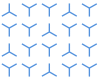

In [12]:
# Send an example image to get a prediction score
input_data_str = "{\"data\": " + str(input_data.tolist()) + "}"

headers = {"Content-Type": "application/json"} 

# Get scoring URI of local webservice
local_scoring_uri = local_service.scoring_uri

resp = requests.post(local_scoring_uri, input_data_str, headers=headers)

print("POST to url", local_service.scoring_uri)
print("Result:", resp.text)

In [ ]:
# # Display the test image
# %matplotlib inline
# plt.imshow(Image.open("../data/fowl_data/test_img.jpg"))

# # Preprocess the image
# input_data = preprocess_image("../data/fowl_data/test_img.jpg")

# # Get header and body for POST request
# input_data = "{\"data\": " + str(input_data.tolist()) + "}"
# headers = {"Content-Type": "application/json"}

# # Get scoring URI
# local_scoring_uri = local_service.scoring_uri

# # Make POST request
# resp = requests.post(local_scoring_uri, input_data, headers=headers)

# print("POST to url", local_scoring_uri)
# print("Result:", resp.text)

# Model Deployment (AKS Compute Target)

This section describes how a local deployment to the Azure Kubernetes Service Experimentation Instance can be done. This is a particular instance of AKS provided for model testing in the Experimentation Stage.

### Retrieve AKS cluster

In [ ]:
# Specify AKS cluster name of the Experimentation Instance
aks_name = "infcluster01" 

# Retrieve all computes from workspace
cts = ws.compute_targets

# Retrieve existing AKS cluster
if aks_name in cts and cts[aks_name].type == "AKS":
    print("Found existing AKS cluster, will use it!\n")
    aks_target = cts[aks_name]
    print("Cluster state:", aks_target.provisioning_state)
    print("Cluster is ready!\n")
    print(aks_target)
else:
    print("Specified AKS cluster does not exist, please use the existing AKS Experimentation Instance")

### Deploy the Model as AKS Webservice

In [ ]:
# Specify webservice name
aks_service_name = "fowl-pytorch-aks-service"

aks_deployment_config = AksWebservice.deploy_configuration(collect_model_data=True,
                                                           enable_app_insights=True)

aks_webservices = Webservice.list(workspace = ws, compute_type="AKS")

if any(aks_webservice.name == aks_service_name for aks_webservice in aks_webservices):
    print("Model with the same service name is already deployed")
else:
    if aks_target.provisioning_state == "Succeeded":
        aks_service = Model.deploy(workspace=ws,
                                   name=aks_service_name,
                                   models=[model],
                                   inference_config=inference_config,
                                   deployment_config=aks_deployment_config,
                                   deployment_target=aks_target)
        
        aks_service.wait_for_deployment(show_output=True)
        print("Service state:", aks_service.state)
        print("Service details:", aks_service)
    else: 
        raise ValueError("Failed to deploy service to AKS - Error: ", aks_service.error)

### Retrieve Existing Webservice

In case the webservice already exists, it can also be retrieved as follows:

In [ ]:
# Specify webservice name
aks_service_name = "fowl-pytorch-aks-service"

aks_service = AksWebservice(ws, aks_service_name)

### Webservice Testing

In the following, the webservice that has been deployed to the AKS Experimentation Instance will be tested. The webservice can either be called using the Python SDK or by sending an HTTP request.

In [ ]:
# Display the test image
%matplotlib inline
plt.imshow(Image.open("../data/fowl_data/example/example_image.jpg"))

#### Python SDK

Use the Python SDK to send input data to the service endpoint and retrieve prediction results.

In [ ]:
# Preprocess the image
input_data = preprocess_image("../data/fowl_data/example/example_image.jpg")

# Run the service
result = aks_service.run(input_data=json.dumps({"data": input_data.tolist()}))
print(result)

In [ ]:
# Get logs in case of issues
# aks_service.get_logs()

#### Send HTTP Request

Send an HTTP request with the Python requests library. This is an example for how any REST API POST operation can retrieve prediction results from the model.

In [ ]:
# Send an example image to get a prediction score
input_data_str = "{\"data\": " + str(input_data.tolist()) + "}"

# For AKS deployment the service key needs to be in the header as well
# AML generate two keys if key auth is enabled
api_key1, api_key2 = aks_service.get_keys()
headers = {"Content-Type": "application/json", "Authorization":("Bearer "+ api_key1)} 

resp = requests.post(aks_service.scoring_uri, input_data_str, headers=headers)

print("POST to url", aks_service.scoring_uri)
print("Result:", resp.text)

# Resource Clean Up

Delete the web services with a simple API call.

In [ ]:
print("Delete local webservice...")
local_service.delete()
print("Delete AKS webservice...")
aks_service.delete()